In [2]:
import importlib, sys, subprocess
packages = "numpy, pandas, matplotlib, scipy, astropy, photutils, ccdproc, version_information" # required modules
pkgs = packages.split(", ")
for pkg in pkgs :
    if not importlib.util.find_spec(pkg):
        print(f"**** module {pkg} is not installed")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
    else: 
        print(f"**** module {pkg} is installed")

**** module numpy is installed
**** module pandas is installed
**** module matplotlib is installed
**** module scipy is installed
**** module astropy is installed
**** module photutils is installed
**** module ccdproc is installed
**** module version_information is installed


In [3]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information {packages}
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2023-10-04 22:24:14 (KST = GMT+0900) 
0 Python     3.11.5 64bit [GCC 11.2.0]
1 IPython    8.15.0
2 OS         Linux 5.15.0 84 generic x86_64 with glibc2.31
3 numpy      1.26.0
4 pandas     2.0.3
5 matplotlib 3.7.2
6 scipy      1.11.1
7 astropy    5.2.1
8 photutils  1.6.0
9 ccdproc    2.4.0
10 version_information 1.0.4


In [5]:
import os
from glob import glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable

import ysfitsutilpy as yfu
import ysphotutilpy as ypu
import ysvisutilpy as yvu

import _Python_utilities
import _astro_utilities

from astropy.nddata import Cutout2D
from astropy.io import fits
from astropy.wcs import WCS

from photutils import DAOStarFinder
from photutils import IRAFStarFinder
from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn
from photutils import detect_threshold
from photutils.centroids import centroid_com
#from photutils import aperture_photometry as apphot

import warnings

from ccdproc import CCDData, ccd_process

from astropy.time import Time
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord

import _astro_utilities
import _Python_utilities

plt.rcParams.update({'figure.max_open_warning': 0})

/home/guitar79/Downloads/ysphotutilpy/ysphotutilpy/seputil.py:112: UserWarning: Package sep is not installed. Some functions will not work.
  warn("Package sep is not installed. Some functions will not work.")
/tmp/ipykernel_23981/1142783936.py:22: DeprecationWarning: `photutils.DAOStarFinder` is a deprecated alias for `photutils.detection.DAOStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import DAOStarFinder` to silence this warning.
  from photutils import DAOStarFinder
/tmp/ipykernel_23981/1142783936.py:23: DeprecationWarning: `photutils.IRAFStarFinder` is a deprecated alias for `photutils.detection.IRAFStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import IRAFStarFinder` to silence this warning.
  from photutils import IRAFStarFinder
/tmp/ipykernel_23981/1142783936.py:26: DeprecationWarning: `photutils.detect_threshold` is a deprecated alias for `photutils.segmentation.detect_threshold` and 

In [6]:
MASTERDIR = '/home/guitar79/Downloads/images'
BASEDIR = MASTERDIR

In [7]:
summary = yfu.make_summary(os.path.join(BASEDIR, "*.fit*"))
#print(summary)
print("len(summary):", len(summary))
print("summary:", summary)
#print(summary["file"][0])

All 31 keywords (guessed from /home/guitar79/Downloads/images/-_Bias_-_2022-11-15-12-01-44_000sec_RiLA600_STX-16803_-20C_2bin.fit) will be loaded.
len(summary): 9
summary:                                                 file  filesize  SIMPLE  \
0  /home/guitar79/Downloads/images/-_Bias_-_2022-...   8392320    True   
1  /home/guitar79/Downloads/images/-_Dark_-_2022-...   8395200    True   
2  /home/guitar79/Downloads/images/-_Flat_R_2022-...   8395200    True   
3  /home/guitar79/Downloads/images/Nightsky_KLEOP...  16790400    True   
4  /home/guitar79/Downloads/images/Raw_KLEOPATRA_...   8398080    True   
5  /home/guitar79/Downloads/images/Reduced_KLEOPA...  16787520    True   
6   /home/guitar79/Downloads/images/master_bias.fits  16784640    True   
7  /home/guitar79/Downloads/images/master_dark_18...  16784640    True   
8  /home/guitar79/Downloads/images/master_flat_R_...  16790400    True   

   BITPIX  NAXIS  NAXIS1  NAXIS2 EXTEND    BZERO IMAGETYP  ...  FOCALLEN  \
0      16  

/home/guitar79/Downloads/ysfitsutilpy/ysfitsutilpy/filemgmt.py:298: UserWarning: Key EXTEND not found for /home/guitar79/Downloads/images/-_Flat_R_2022-10-25-08-49-10_000sec_RiLA600_STX-16803_-25C_2bin.fit, filling with None.
  warn(str_keyerror_fill.format(k, str(item)))
/home/guitar79/Downloads/ysfitsutilpy/ysfitsutilpy/filemgmt.py:298: UserWarning: Key DATE-LOC not found for /home/guitar79/Downloads/images/-_Flat_R_2022-10-25-08-49-10_000sec_RiLA600_STX-16803_-25C_2bin.fit, filling with None.
  warn(str_keyerror_fill.format(k, str(item)))
/home/guitar79/Downloads/ysfitsutilpy/ysfitsutilpy/filemgmt.py:298: UserWarning: Key FOCRATIO not found for /home/guitar79/Downloads/images/-_Flat_R_2022-10-25-08-49-10_000sec_RiLA600_STX-16803_-25C_2bin.fit, filling with None.
  warn(str_keyerror_fill.format(k, str(item)))
/home/guitar79/Downloads/ysfitsutilpy/ysfitsutilpy/filemgmt.py:298: UserWarning: Key OBJCTRA not found for /home/guitar79/Downloads/images/-_Flat_R_2022-10-25-08-49-10_000sec_Ri

In [19]:
_fits = summary.copy()
_fits.reset_index(inplace=True)
_fits = _fits["file"]

print(type(_fits))
print(len(_fits))
print(_fits)

<class 'pandas.core.series.Series'>
9
0    /home/guitar79/Downloads/images/-_Bias_-_2022-...
1    /home/guitar79/Downloads/images/-_Dark_-_2022-...
2    /home/guitar79/Downloads/images/-_Flat_R_2022-...
3    /home/guitar79/Downloads/images/Nightsky_KLEOP...
4    /home/guitar79/Downloads/images/Raw_KLEOPATRA_...
5    /home/guitar79/Downloads/images/Reduced_KLEOPA...
6     /home/guitar79/Downloads/images/master_bias.fits
7    /home/guitar79/Downloads/images/master_dark_18...
8    /home/guitar79/Downloads/images/master_flat_R_...
Name: file, dtype: object


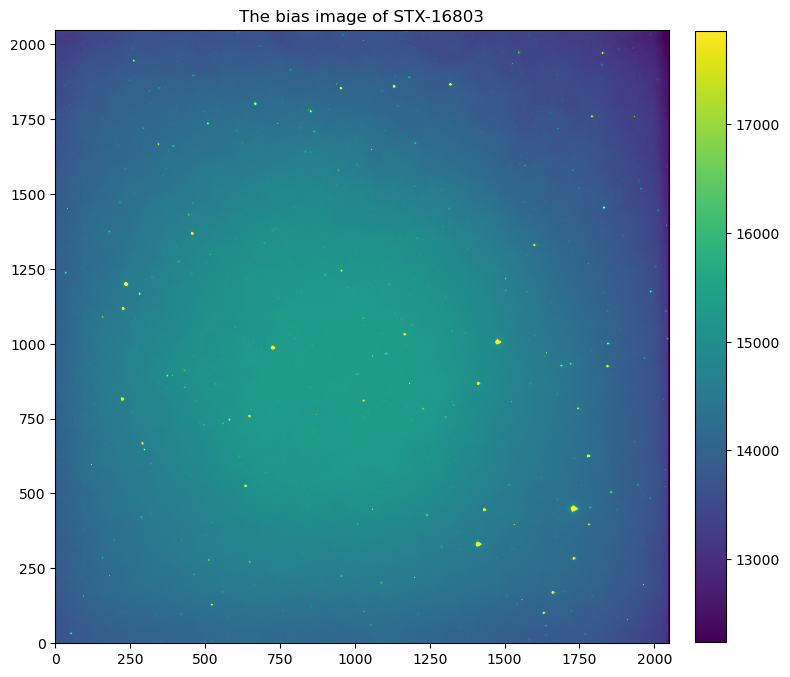

In [26]:
hdul = fits.open(_fits[4])

fig, axs = plt.subplots(1, 1, figsize=(8, 8), sharex=False, sharey=False, gridspec_kw=None)
im = yvu.zimshow(axs, hdul[0].data)
axs.set_title('The bias image of STX-16803')
plt.colorbar(im, fraction=0.0455, pad=0.04)
plt.tight_layout()

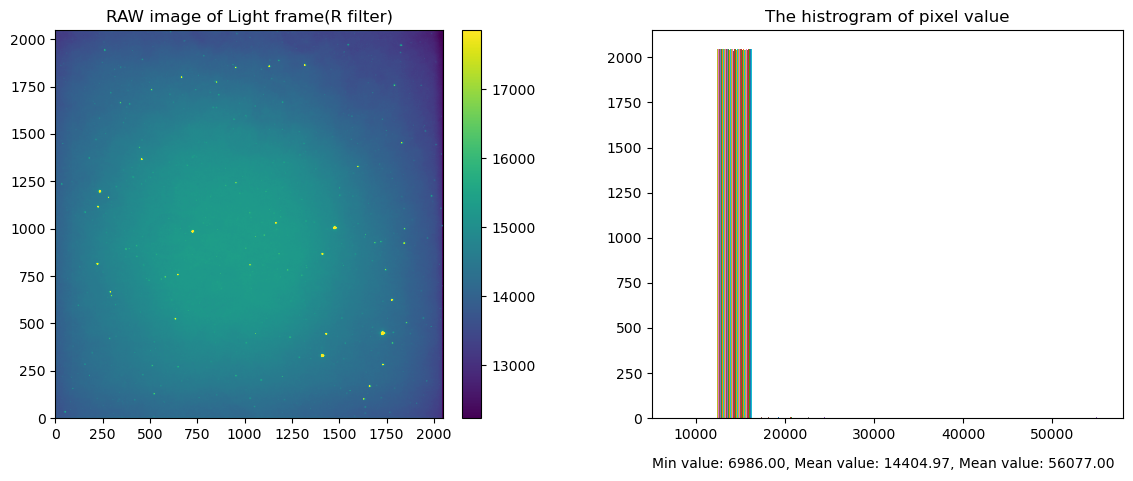

In [32]:
hdul = fits.open(_fits[4])

fig, axs = plt.subplots(1, 2, figsize=(13, 6), sharex=False, sharey=False, gridspec_kw=None)

im1 = yvu.zimshow(axs[0], hdul[0].data)
im2 = axs[1].hist(hdul[0].data 
                    #histtype='step',
                    #50 
                    )

axs[0].set_title('RAW image of Light frame(R filter)')
axs[1].set_title('The histrogram of pixel value')

plt.annotate(f"Min value: {hdul[0].data.min():.02f}, Mean value: {hdul[0].data.mean():.02f}, Mean value: {hdul[0].data.max():.02f}", xy=(0, -50), xycoords='axes pixels')

plt.colorbar(im1, fraction=0.0455, pad=0.04)
plt.tight_layout(pad=5.0)
plt.savefig('/home/guitar79/Downloads/images/histogram'+'raw.pdf')
plt.savefig('/home/guitar79/Downloads/images/histogram'+'raw.png')

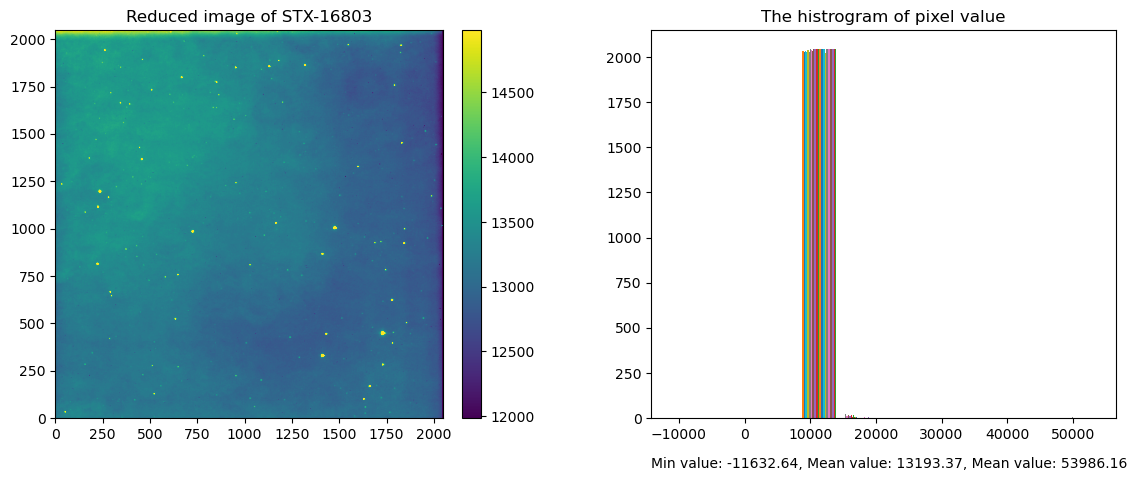

In [33]:
hdul = fits.open(_fits[5])

fig, axs = plt.subplots(1, 2, figsize=(13, 6), sharex=False, sharey=False, gridspec_kw=None)

im1 = yvu.zimshow(axs[0], hdul[0].data)
im2 = axs[1].hist(hdul[0].data 
                    #histtype='step',
                    #50 
                    )

axs[0].set_title('Reduced image of STX-16803')
axs[1].set_title('The histrogram of pixel value')

plt.annotate(f"Min value: {hdul[0].data.min():.02f}, Mean value: {hdul[0].data.mean():.02f}, Mean value: {hdul[0].data.max():.02f}", xy=(0, -50), xycoords='axes pixels')

plt.colorbar(im1, fraction=0.0455, pad=0.04)
plt.tight_layout(pad=5.0)
plt.savefig('/home/guitar79/Downloads/images/histogram'+'reduced.pdf')
plt.savefig('/home/guitar79/Downloads/images/histogram'+'reduced.png')

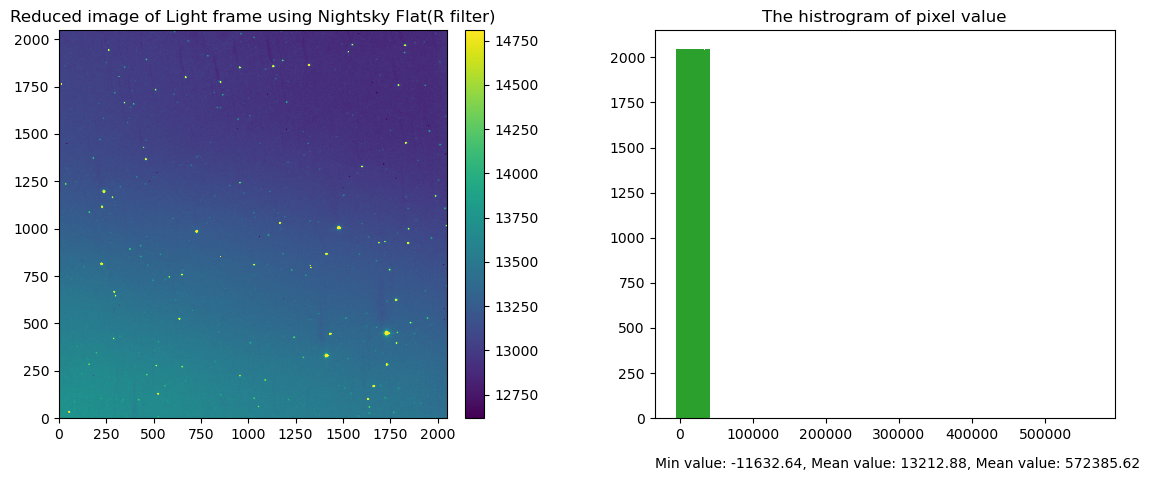

In [34]:
hdul = fits.open(_fits[3])

fig, axs = plt.subplots(1, 2, figsize=(13, 6), sharex=False, sharey=False, gridspec_kw=None)

im1 = yvu.zimshow(axs[0], hdul[0].data)
im2 = axs[1].hist(hdul[0].data 
                    #histtype='step',
                    #50 
                    )

axs[0].set_title('Reduced image of Light frame using Nightsky Flat(R filter)')
axs[1].set_title('The histrogram of pixel value')

plt.annotate(f"Min value: {hdul[0].data.min():.02f}, Mean value: {hdul[0].data.mean():.02f}, Mean value: {hdul[0].data.max():.02f}", xy=(0, -50), xycoords='axes pixels')

plt.colorbar(im1, fraction=0.0455, pad=0.04)
plt.tight_layout(pad=5.0)
plt.savefig('/home/guitar79/Downloads/images/histogram'+'nightsky.pdf')
plt.savefig('/home/guitar79/Downloads/images/histogram'+'nightsky.png')